# Synthetic Dataset & Scalability
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate our structural preservation metrics on a synthetic dataset of known high-dimensional structure and determine their scalability to datasets with a large number of observations.__  

As a reminder, unique pairwise distances in a dataset with _n_ cells is calculated as:  
$$D=(n*(n-1))/2$$  
  
To benchmark these techniques, we are using a **"Swiss Roll"** dataset built using `sklearn.datasets.make_swiss_roll()`.

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *

In [71]:
# reload functions when editing file
del sys.modules['fcc_utils']
from fcc_utils import *

In [2]:
from sklearn import datasets # for swiss roll dataset
import mpl_toolkits.mplot3d.axes3d as p3 # 3D plotting

In [3]:
# create dictionaries for dumping results into
final_distance_stats = {1000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}, 'Time':{}}, 
                        10000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}, 'Time':{}}, 
                        50000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}, 'Time':{}}, 
                        100000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}, 'Time':{}}
                       }

---
### 1K-Point Swiss Roll

In [4]:
X, t = datasets.make_swiss_roll(n_samples=1000, noise=0.0, random_state=18)

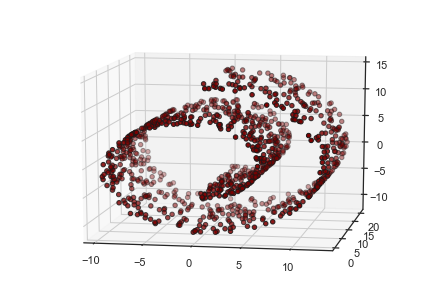

In [5]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [6]:
swiss_1k = sc.AnnData(X=X) # initialize AnnData
swiss_1k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_1k

AnnData object with n_obs × n_vars = 1000 × 3 
    obs: 'pos'

In [9]:
# perform PCA
%time sc.tl.pca(swiss_1k, n_comps=2)

CPU times: user 6.77 ms, sys: 2.74 ms, total: 9.51 ms
Wall time: 2.37 ms


In [10]:
# create neighborhood graphs from PCA results for UMAP and Louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
%time sc.pp.neighbors(swiss_1k, n_neighbors=30, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compile

CPU times: user 2.85 s, sys: 106 ms, total: 2.96 s
Wall time: 2.56 s


In [11]:
%%time
# perform Louvain clustering
sc.tl.louvain(swiss_1k, resolution=0.5, key_added='louvain', random_state=18, copy=False)
# put cluster names in string column of .obs for plotting
swiss_1k.obs['clusterID'] = 'cluster_' + swiss_1k.obs['louvain'].astype(str)

CPU times: user 57.8 ms, sys: 2.71 ms, total: 60.5 ms
Wall time: 59.7 ms


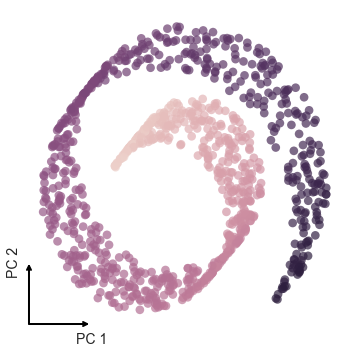

In [12]:
DR_plot(dim_name='PC').plot(swiss_1k.obsm['X_pca'], color=swiss_1k.obs['pos'])

In [14]:
# perform UMAP
%time sc.tl.umap(swiss_1k, random_state=18)

CPU times: user 2.97 s, sys: 92.1 ms, total: 3.06 s
Wall time: 2.59 s


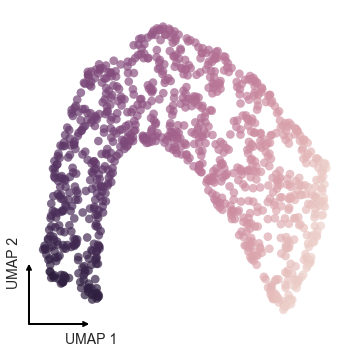

In [15]:
DR_plot(dim_name='UMAP').plot(swiss_1k.obsm['X_umap'], color=swiss_1k.obs['pos'])

In [16]:
# perform t-SNE
%time sc.tl.tsne(swiss_1k, use_rep='X', perplexity=30, random_state=18)

CPU times: user 4.07 s, sys: 6.19 ms, total: 4.08 s
Wall time: 4.08 s


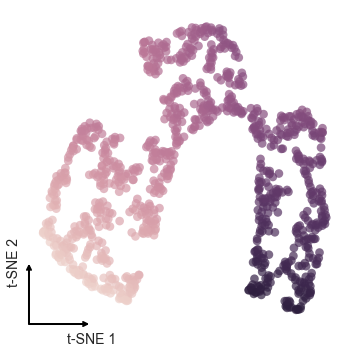

In [17]:
DR_plot(dim_name='t-SNE').plot(swiss_1k.obsm['X_tsne'], color=swiss_1k.obs['pos'])

In [18]:
%%time
# save distance matrices in AnnData object for easy access
swiss_1k.uns['tsne_distance'] = pdist(swiss_1k.obsm['X_tsne'])
swiss_1k.uns['umap_distance'] = pdist(swiss_1k.obsm['X_umap'])
swiss_1k.uns['pca_distance'] = pdist(swiss_1k.obsm['X_pca'])
swiss_1k.uns['native_distance'] = pdist(swiss_1k.X)

CPU times: user 6.33 ms, sys: 2.54 ms, total: 8.87 ms
Wall time: 7.9 ms


R: 0.8567
EMD: 0.0386
CPU times: user 999 ms, sys: 117 ms, total: 1.12 s
Wall time: 484 ms


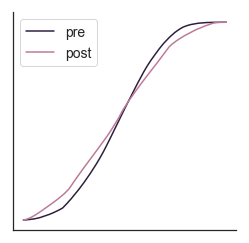

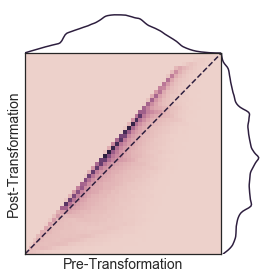

In [19]:
%%time
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_1k.uns['native_distance'], post=swiss_1k.uns['pca_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[1000]['R']['PCA (2)'], final_distance_stats[1000]['EMD']['PCA (2)'] = mantel_stats[0], EMD

R: 0.38
EMD: 0.0499
CPU times: user 993 ms, sys: 110 ms, total: 1.1 s
Wall time: 470 ms


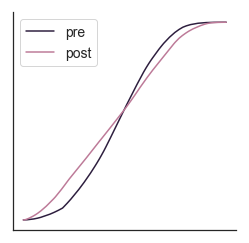

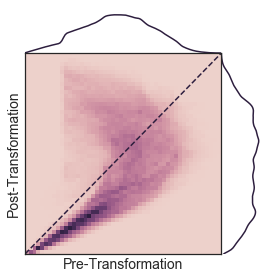

In [20]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_1k.uns['native_distance'], post=swiss_1k.uns['tsne_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[1000]['R']['t-SNE'], final_distance_stats[1000]['EMD']['t-SNE'] = mantel_stats[0], EMD

R: 0.2716
EMD: 0.0772
CPU times: user 989 ms, sys: 108 ms, total: 1.1 s
Wall time: 467 ms


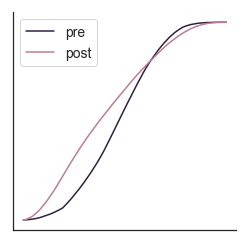

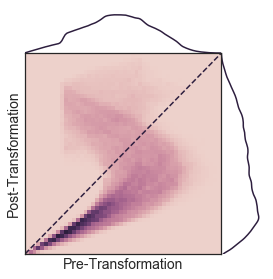

In [21]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_1k.uns['native_distance'], post=swiss_1k.uns['umap_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[1000]['R']['UMAP'], final_distance_stats[1000]['EMD']['UMAP'] = mantel_stats[0], EMD

---
### 10K-Point Swiss Roll

In [22]:
X, t = datasets.make_swiss_roll(n_samples=10000, noise=0.0, random_state=18)

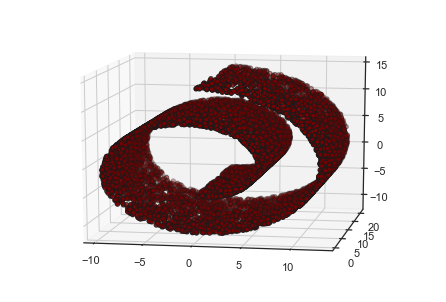

In [23]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [24]:
swiss_10k = sc.AnnData(X=X) # initialize AnnData
swiss_10k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_10k

AnnData object with n_obs × n_vars = 10000 × 3 
    obs: 'pos'

In [25]:
# perform PCA
%time sc.tl.pca(swiss_10k, n_comps=2)

CPU times: user 10.6 ms, sys: 19.8 ms, total: 30.3 ms
Wall time: 4.19 ms


In [26]:
# create neighborhood graphs from PCA results for UMAP and Louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(swiss_10k, n_neighbors=100, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<funct

In [27]:
%%time
# perform Louvain clustering
sc.tl.louvain(swiss_10k, resolution=0.5, key_added='louvain', random_state=18, copy=False)
# put cluster names in string column of .obs for plotting
swiss_10k.obs['clusterID'] = 'cluster_' + swiss_10k.obs['louvain'].astype(str)

CPU times: user 3.49 s, sys: 66.6 ms, total: 3.55 s
Wall time: 3.56 s


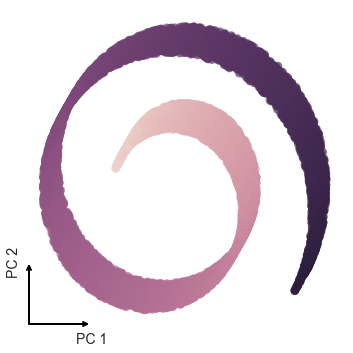

In [28]:
DR_plot(dim_name='PC').plot(swiss_10k.obsm['X_pca'], color=swiss_10k.obs['pos'])

In [29]:
# perform UMAP
%time sc.tl.umap(swiss_10k, random_state=18)

CPU times: user 21.7 s, sys: 426 ms, total: 22.1 s
Wall time: 19.4 s


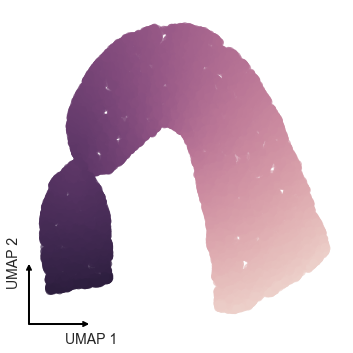

In [30]:
DR_plot(dim_name='UMAP').plot(swiss_10k.obsm['X_umap'], color=swiss_10k.obs['pos'])

In [31]:
# perform t-SNE
%time sc.tl.tsne(swiss_10k, use_rep='X', perplexity=100, random_state=18)

CPU times: user 1min 10s, sys: 444 ms, total: 1min 10s
Wall time: 1min 11s


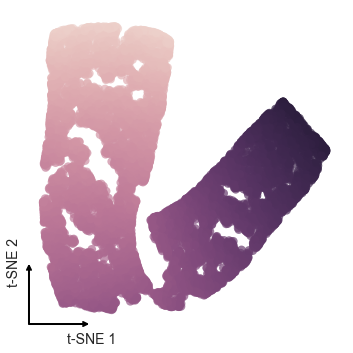

In [32]:
DR_plot(dim_name='t-SNE').plot(swiss_10k.obsm['X_tsne'], color=swiss_10k.obs['pos'])

In [33]:
%%time
# save distance matrices in AnnData object for easy access
swiss_10k.uns['tsne_distance'] = pdist(swiss_10k.obsm['X_tsne'])
swiss_10k.uns['umap_distance'] = pdist(swiss_10k.obsm['X_umap'])
swiss_10k.uns['pca_distance'] = pdist(swiss_10k.obsm['X_pca'])
swiss_10k.uns['native_distance'] = pdist(swiss_10k.X)

CPU times: user 599 ms, sys: 251 ms, total: 849 ms
Wall time: 849 ms


R: 0.8512
EMD: 0.051
CPU times: user 52.5 s, sys: 4.26 s, total: 56.7 s
Wall time: 56 s


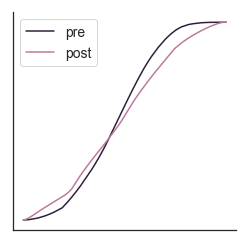

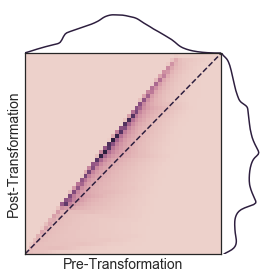

In [34]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_10k.uns['native_distance'], post=swiss_10k.uns['pca_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[10000]['R']['PCA (2)'], final_distance_stats[10000]['EMD']['PCA (2)'] = mantel_stats[0], EMD

R: 0.4178
EMD: 0.0448
CPU times: user 52.6 s, sys: 2.87 s, total: 55.5 s
Wall time: 54.6 s


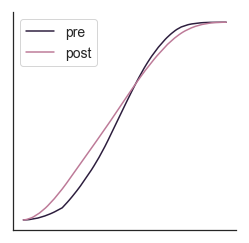

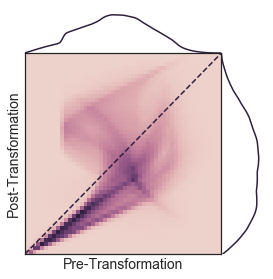

In [35]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_10k.uns['native_distance'], post=swiss_10k.uns['tsne_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[10000]['R']['t-SNE'], final_distance_stats[10000]['EMD']['t-SNE'] = mantel_stats[0], EMD

R: 0.3486
EMD: 0.0528
CPU times: user 53.2 s, sys: 3.3 s, total: 56.5 s
Wall time: 55.7 s


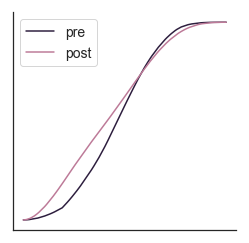

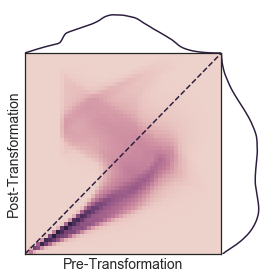

In [36]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_10k.uns['native_distance'], post=swiss_10k.uns['umap_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[10000]['R']['UMAP'], final_distance_stats[10000]['EMD']['UMAP'] = mantel_stats[0], EMD

---
### 50K-Point Swiss Roll

In [44]:
X, t = datasets.make_swiss_roll(n_samples=50000, noise=0.0, random_state=18)

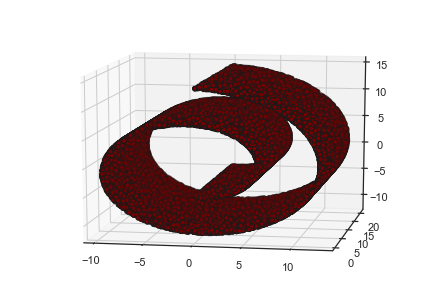

In [45]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [46]:
swiss_50k = sc.AnnData(X=X) # initialize AnnData
swiss_50k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_50k

AnnData object with n_obs × n_vars = 50000 × 3 
    obs: 'pos'

In [47]:
# perform PCA
%time sc.tl.pca(swiss_50k, n_comps=2)

CPU times: user 37 ms, sys: 60.9 ms, total: 97.8 ms
Wall time: 12.5 ms


In [48]:
# create neighborhood graphs from PCA results for UMAP and Louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
%time sc.pp.neighbors(swiss_50k, n_neighbors=225, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


CPU times: user 1min 2s, sys: 1.03 s, total: 1min 3s
Wall time: 1min 2s


In [49]:
%%time
# perform Louvain clustering
sc.tl.louvain(swiss_50k, resolution=0.5, key_added='louvain', random_state=18, copy=False)
# put cluster names in string column of .obs for plotting
swiss_50k.obs['clusterID'] = 'cluster_' + swiss_50k.obs['louvain'].astype(str)

CPU times: user 1min 22s, sys: 876 ms, total: 1min 23s
Wall time: 1min 23s


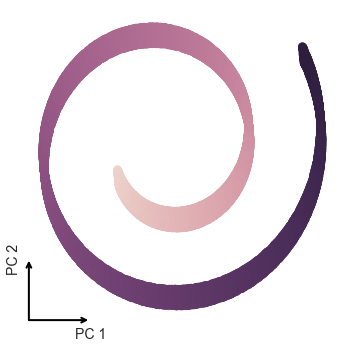

In [50]:
DR_plot(dim_name='PC').plot(swiss_50k.obsm['X_pca'], color=swiss_50k.obs['pos'])

In [51]:
# perform UMAP
%time sc.tl.umap(swiss_50k, random_state=18)

CPU times: user 1min 44s, sys: 3.97 s, total: 1min 48s
Wall time: 1min 2s


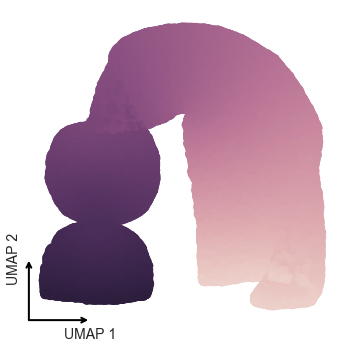

In [52]:
DR_plot(dim_name='UMAP').plot(swiss_50k.obsm['X_umap'], color=swiss_50k.obs['pos'])

In [73]:
# perform t-SNE
%time sc.tl.tsne(swiss_50k, use_rep='X', perplexity=225, random_state=18)

CPU times: user 10min 44s, sys: 6.37 s, total: 10min 50s
Wall time: 10min 51s


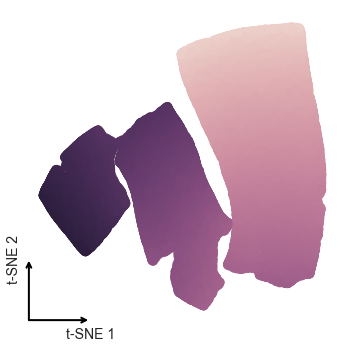

In [74]:
DR_plot(dim_name='t-SNE').plot(swiss_50k.obsm['X_tsne'], color=swiss_50k.obs['pos'])

In [75]:
%%time
# save distance matrices in AnnData object for easy access
swiss_50k.uns['tsne_distance'] = pdist(swiss_50k.obsm['X_tsne'])
swiss_50k.uns['umap_distance'] = pdist(swiss_50k.obsm['X_umap'])
swiss_50k.uns['pca_distance'] = pdist(swiss_50k.obsm['X_pca'])
swiss_50k.uns['native_distance'] = pdist(swiss_50k.X)

CPU times: user 14.7 s, sys: 6.73 s, total: 21.4 s
Wall time: 21.4 s


R: 0.851
EMD: 0.0486
CPU times: user 2min 21s, sys: 37.4 s, total: 2min 58s
Wall time: 3min 9s


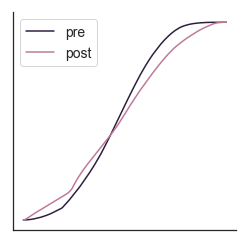

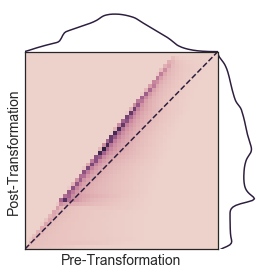

In [76]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_50k.uns['native_distance'], post=swiss_50k.uns['pca_distance'], downsample=49995000)
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[50000]['R']['PCA (2)'], final_distance_stats[50000]['EMD']['PCA (2)'] = mantel_stats[0], EMD

R: 0.3969
EMD: 0.0648
CPU times: user 2min 27s, sys: 20.5 s, total: 2min 48s
Wall time: 2min 51s


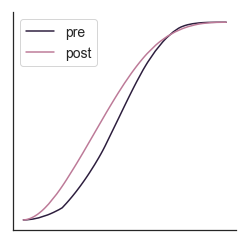

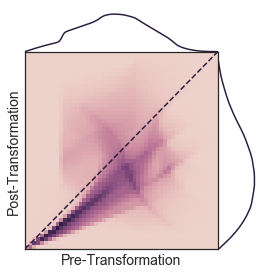

In [77]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_50k.uns['native_distance'], post=swiss_50k.uns['tsne_distance'], downsample=49995000)
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[50000]['R']['t-SNE'], final_distance_stats[50000]['EMD']['t-SNE'] = mantel_stats[0], EMD

R: 0.4271
EMD: 0.0457
CPU times: user 2min 17s, sys: 19.7 s, total: 2min 37s
Wall time: 2min 53s


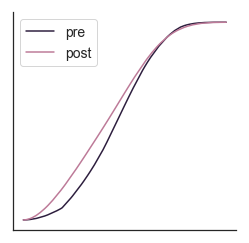

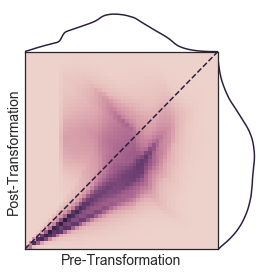

In [78]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_50k.uns['native_distance'], post=swiss_50k.uns['umap_distance'], downsample=49995000)
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[50000]['R']['UMAP'], final_distance_stats[50000]['EMD']['UMAP'] = mantel_stats[0], EMD

---
### 100K-Point Swiss Roll

In [79]:
X, t = datasets.make_swiss_roll(n_samples=100000, noise=0.0, random_state=18)

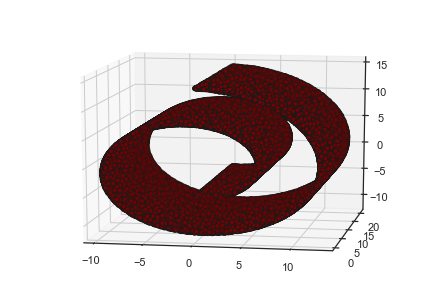

In [80]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [81]:
swiss_100k = sc.AnnData(X=X) # initialize AnnData
swiss_100k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_100k

AnnData object with n_obs × n_vars = 100000 × 3 
    obs: 'pos'

In [82]:
# perform PCA
%time sc.tl.pca(swiss_100k, n_comps=2)

CPU times: user 157 ms, sys: 92.5 ms, total: 250 ms
Wall time: 32.1 ms


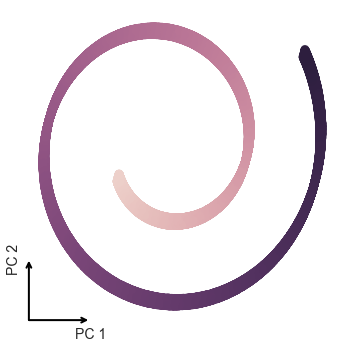

In [83]:
DR_plot(dim_name='PC').plot(swiss_100k.obsm['X_pca'], color=swiss_100k.obs['pos'])

In [84]:
# create neighborhood graphs from PCA results for UMAP and Louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(swiss_100k, n_neighbors=300, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


KeyboardInterrupt: 

In [ ]:
# perform UMAP
%time sc.tl.umap(swiss_100k, random_state=18)

In [ ]:
DR_plot(dim_name='UMAP').plot(swiss_100k.obsm['X_umap'], color=swiss_100k.obs['pos'])

In [ ]:
# perform t-SNE
%time sc.tl.tsne(swiss_100k, use_rep='X', perplexity=300, random_state=18)

In [ ]:
DR_plot(dim_name='t-SNE').plot(swiss_100k.obsm['X_tsne'], color=swiss_100k.obs['pos'])

In [ ]:
%%time
# save distance matrices in AnnData object for easy access
swiss_100k.uns['tsne_distance'] = pdist(swiss_100k.obsm['X_tsne'])
swiss_100k.uns['umap_distance'] = pdist(swiss_100k.obsm['X_umap'])
swiss_100k.uns['pca_distance'] = pdist(swiss_100k.obsm['X_pca'])
swiss_100k.uns['native_distance'] = pdist(swiss_100k.X)

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_100k.uns['native_distance'], post=swiss_100k.uns['pca_distance'], downsample=49995000)
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[100000]['R']['PCA (2)'], final_distance_stats[100000]['EMD']['PCA (2)'] = mantel_stats[0], EMD

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_100k.uns['native_distance'], post=swiss_100k.uns['tsne_distance'], downsample=49995000)
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[100000]['R']['t-SNE'], final_distance_stats[100000]['EMD']['t-SNE'] = mantel_stats[0], EMD

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_100k.uns['native_distance'], post=swiss_100k.uns['umap_distance'], downsample=49995000)
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[100000]['R']['UMAP'], final_distance_stats[100000]['EMD']['UMAP'] = mantel_stats[0], EMD

---
### Knn Preservation

In [ ]:
%%time
knn_graph(distance_matrix(swiss_1k.X, swiss_1k.X), k=30, swiss_1k, save_rep='native_knn')
knn_graph(distance_matrix(swiss_1k.obsm['X_pca'], swiss_1k.obsm['X_pca']), k=30, swiss_1k, save_rep='pca_knn')
knn_graph(distance_matrix(swiss_1k.obsm['X_tsne'], swiss_1k.obsm['X_tsne']), k=30, swiss_1k, save_rep='tsne_knn')
knn_graph(distance_matrix(swiss_1k.obsm['X_umap'], swiss_1k.obsm['X_umap']), k=30, swiss_1k, save_rep='umap_knn')

In [ ]:
final_distance_stats[1000]['Knn Pres.']['PCA (2)'] = knn_preservation(pre=swiss_1k.uns['native_knn'], post=swiss_1k.uns['pca_knn'])
final_distance_stats[1000]['Knn Pres.']['t-SNE'] = knn_preservation(pre=swiss_1k.uns['native_knn'], post=swiss_1k.uns['tsne_knn'])
final_distance_stats[1000]['Knn Pres.']['UMAP'] = knn_preservation(pre=swiss_1k.uns['native_knn'], post=swiss_1k.uns['umap_knn'])

In [ ]:
%%time
knn_graph(distance_matrix(swiss_10k.X, swiss_10k.X), k=100, swiss_10k, save_rep='native_knn')
knn_graph(distance_matrix(swiss_10k.obsm['X_pca'], swiss_10k.obsm['X_pca']), k=100, swiss_10k, save_rep='pca_knn')
knn_graph(distance_matrix(swiss_10k.obsm['X_tsne'], swiss_10k.obsm['X_tsne']), k=100, swiss_10k, save_rep='tsne_knn')
knn_graph(distance_matrix(swiss_10k.obsm['X_umap'], swiss_10k.obsm['X_umap']), k=100, swiss_10k, save_rep='umap_knn')

In [ ]:
final_distance_stats[10000]['Knn Pres.']['PCA (2)'] = knn_preservation(pre=swiss_10k.uns['native_knn'], post=swiss_10k.uns['pca_knn'])
final_distance_stats[10000]['Knn Pres.']['t-SNE'] = knn_preservation(pre=swiss_10k.uns['native_knn'], post=swiss_10k.uns['tsne_knn'])
final_distance_stats[10000]['Knn Pres.']['UMAP'] = knn_preservation(pre=swiss_10k.uns['native_knn'], post=swiss_10k.uns['umap_knn'])

In [ ]:
%%time
knn_graph(distance_matrix(swiss_100k.X, swiss_100k.X), k=300, swiss_100k, save_rep='native_knn')
knn_graph(distance_matrix(swiss_100k.obsm['X_pca'], swiss_100k.obsm['X_pca']), k=300, swiss_100k, save_rep='pca_knn')
knn_graph(distance_matrix(swiss_100k.obsm['X_tsne'], swiss_100k.obsm['X_tsne']), k=300, swiss_100k, save_rep='tsne_knn')
knn_graph(distance_matrix(swiss_100k.obsm['X_umap'], swiss_100k.obsm['X_umap']), k=300, swiss_100k, save_rep='umap_knn')

In [ ]:
final_distance_stats[100000]['Knn Pres.']['PCA (2)'] = knn_preservation(pre=swiss_100k.uns['native_knn'], post=swiss_100k.uns['pca_knn'])
final_distance_stats[100000]['Knn Pres.']['t-SNE'] = knn_preservation(pre=swiss_100k.uns['native_knn'], post=swiss_100k.uns['tsne_knn'])
final_distance_stats[100000]['Knn Pres.']['UMAP'] = knn_preservation(pre=swiss_100k.uns['native_knn'], post=swiss_100k.uns['umap_knn'])

---
### Timing

In [ ]:
times = %timeit -n 1 -r 3 distance_stats(pre=swiss_1k.uns['native_distance'], post=swiss_1k.uns['pca_distance'])